In [391]:
import sprf
from sprf.spatial_random_forest import SpatialRandomForest
from sprf.geographical_random_forest import GeographicalRandomForest
import glob
import geopandas as gpd
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import contextily as cx
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import geocube
from geocube.api.core import make_geocube
import rasterio as rio
from rasterio.plot import show
import scipy
from sklearn.metrics import mean_squared_error
from sklearn.metrics import cohen_kappa_score
import seaborn as sns

In [3]:
!cd

C:\Users\Chad\Desktop\CRWA Project\CRWA-Regional-Tree-Planting-and-Protection-Plan\CRWA-Regional-Tree-Planting-and-Protection-Plan\Notebooks


# Get and clean data from harmonic regression

In [4]:
# Get file paths for all the harmonic regression results
harmreg_fps=glob.glob('../../../Working_Data/*harmreg*')
harmreg_fps

['../../../Working_Data\\B11harmreg.csv',
 '../../../Working_Data\\B12harmreg.csv',
 '../../../Working_Data\\B2harmreg.csv',
 '../../../Working_Data\\B3harmreg.csv',
 '../../../Working_Data\\B4harmreg.csv',
 '../../../Working_Data\\B5harmreg.csv',
 '../../../Working_Data\\B6harmreg.csv',
 '../../../Working_Data\\B7harmreg.csv',
 '../../../Working_Data\\B8Aharmreg.csv',
 '../../../Working_Data\\B8harmreg.csv',
 '../../../Working_Data\\NBRharmreg.csv',
 '../../../Working_Data\\NDVIharmreg.csv',
 '../../../Working_Data\\RENDVIharmreg.csv',
 '../../../Working_Data\\SAVIharmreg.csv']

In [5]:
#Read in all cleaned data
AllData=gpd.read_file('../../../Working_Data/2023BandsIndicesCleaned.shp',engine="pyogrio").dropna()

In [6]:
# DataFrame with PtID and their corresponding geometries
PointsIDCrossWalk=AllData[['PtID','geometry']].drop_duplicates().reset_index()

In [7]:
#Note that in creating the data in the HPC, somehow some [] got added so these were removed in notepad
#Looping through each chunk of harmonic regression results and using PtID crosswalk to recombine everything 
bandsInd=['B3','B4','B5','B6','B7','B8','B8A','B11','B12','NBR','NDVI','RENDVI','SAVI']
current=pd.read_csv('../../../Working_Data/B2harmreg.csv').iloc[:53064,:]

#When exporting data from HPC, PtID was incorrectly assigned so is fixed here
current['PtID']=current.index
current['RMSE']=current['RMSE'].to_list()

#Joining data for first dataset and then looping through the rest
joined_gdf=PointsIDCrossWalk.join(current, on='PtID',rsuffix='B2')
for band in bandsInd:
    current=pd.read_csv('../../../Working_Data/'+band+'harmreg.csv').iloc[:53064,:]
    current['RMSE']=current['RMSE'].to_list()
    current['PtID']=current.index
    joined_gdf=joined_gdf.join(current, on='PtID',rsuffix=band)

In [8]:
joined_gdf.drop(['index','Unnamed: 0','PtIDB2','PtIDB3','PtIDB4','PtIDB5','PtIDB6','PtIDB7','PtIDB8','PtIDB8A','PtIDB11','PtIDB12','PtIDNBR','PtIDNDVI','PtIDRENDVI','PtIDSAVI'], axis=1, inplace=True)

In [9]:
joined_gdf.columns

Index(['PtID', 'geometry', 'RMSE', 'a', 'b', 'c', 'd', 'e', 'f', 'g',
       ...
       'RMSESAVI', 'aSAVI', 'bSAVI', 'cSAVI', 'dSAVI', 'eSAVI', 'fSAVI',
       'gSAVI', 'hSAVI', 'iSAVI'],
      dtype='object', length=155)

In [10]:
joined_gdf

PtID                    geometry      RMSE         a         b  \
0          0  POINT (-71.18363 42.27880)  0.108714  0.082168  0.018238   
1          1  POINT (-71.18354 42.27889)  0.109872  0.082926  0.016195   
2          2  POINT (-71.18354 42.27880)  0.109715  0.082934  0.019384   
3          3  POINT (-71.18363 42.27871)  0.108432  0.084420  0.023075   
4          4  POINT (-71.18354 42.27871)  0.109394  0.084496  0.022739   
...      ...                         ...       ...       ...       ...   
52617  53058  POINT (-71.12299 42.26838)  0.130107  0.086000 -0.012173   
52618  53060  POINT (-71.12281 42.26767)  0.132368  0.081331 -0.023482   
52619  53061  POINT (-71.12272 42.26767)  0.132051  0.083370 -0.020887   
52620  53062  POINT (-71.12263 42.26767)  0.132178  0.083179 -0.018949   
52621  53063  POINT (-71.12254 42.26767)  0.127964  0.096321 -0.016284   

              c         d         e         f         g  ...  RMSESAVI  \
0      0.002908  0.008055  0.011457 -0.031858  0.040369  ...  0.093187   
1      0.003335  0.005731  0.012650 -0.034720  0.039413  ...  0.082235   
2      0.003114  0.007526  0.013223 -0.032818  0.041757  ...  0.093993   
3      0.004499  0.009740  0.013271 -0.029711  0.041747  ...  0.096920   
4      0.004970  0.010524  0.014203 -0.031255  0.043595  ...  0.096329   
...         ...       ...       ...       ...       ...  ...       ...   
52617  0.011096  0.024114  0.040270 -0.016385  0.019722  ...  0.115792   
52618  0.009601  0.029991  0.031841 -0.023295  0.013198  ...  0.106719   
52619  0.010890  0.028380  0.034054 -0.020636  0.012929  ...  0.107044   
52620  0.010371  0.027976  0.034181 -0.018406  0.012766  ...  0.102038   
52621  0.009705  0.031244  0.034498 -0.012833  0.016474  ...  0.072362   

          aSAVI     bSAVI     cSAVI     dSAVI     eSAVI     fSAVI     gSAVI  \
0      0.308574 -0.177817 -0.052801  0.025765 -0.005500  0.025471  0.004845   
1      0.274358 -0.194771 -0.020712  0.027089  0.003627  0.028306  0.017664   
2      0.310439 -0.197714 -0.046636  0.025042 -0.003893  0.027430  0.017192   
3      0.309838 -0.170040 -0.063541  0.030032 -0.009159  0.024926  0.006730   
4      0.314740 -0.179227 -0.054586  0.029666 -0.010468  0.024998  0.012149   
...         ...       ...       ...       ...       ...       ...       ...   
52617  0.359297 -0.209285 -0.063625  0.011961 -0.023933  0.004018  0.031710   
52618  0.311730 -0.186851 -0.084163 -0.012175 -0.020367  0.025501  0.035422   
52619  0.313599 -0.177302 -0.079380 -0.017087 -0.019076  0.021610  0.031283   
52620  0.301431 -0.160054 -0.080544 -0.014149 -0.011086  0.019898  0.029993   
52621  0.220291 -0.105141 -0.064419 -0.027409 -0.005914  0.006828  0.026198   

          hSAVI     iSAVI  
0     -0.049908 -0.019157  
1     -0.034463 -0.013317  
2     -0.045066 -0.017068  
3     -0.046710 -0.023122  
4     -0.047793 -0.019820  
...         ...       ...  
52617 -0.064396 -0.013665  
52618 -0.061444 -0.004071  
52619 -0.064237 -0.006490  
52620 -0.054372 -0.011169  
52621 -0.038421 -0.000355  

[52622 rows x 155 columns]

# Split into test, train, and validation datasets

# Training sites from iNaturalist

In [11]:
#Boston boundary
towns=gpd.read_file('../../../Raw_Data/CENSUS2020TOWNS_SHP/CENSUS2020TOWNS_POLY.shp').to_crs(epsg=3857).dissolve('NAMELSAD20')
Boston_gdf=towns[towns.index=='Boston city']

In [12]:
#Deciduous Forests
forestpolygons=gpd.read_file('../../../Working_Data/dforestBoston.shp').to_crs(epsg=3857)

In [16]:
# Multiflora rose, bittersweet, glossy buckthorn
bittersweet=gpd.read_file('../../../Working_Data/Invasives/Bittersweet.shp',engine="pyogrio").clip(forestpolygons)
multiflora=gpd.read_file('../../../Working_Data/Invasives/Multiflora.shp',engine="pyogrio").clip(forestpolygons)
buckthorn=gpd.read_file('../../../Working_Data/Invasives/Buckthorn.shp',engine="pyogrio").clip(forestpolygons)
greenbrier=gpd.read_file('../../../Working_Data/Invasives/Greenbrier.shp',engine="pyogrio").clip(forestpolygons)
laurel=gpd.read_file('../../../Working_Data/Invasives/Laurel.shp',engine="pyogrio").clip(forestpolygons)

In [17]:
bittersweet['invasive']=1
multiflora['invasive']=1
buckthorn['invasive']=1
greenbrier['invasive']=0
laurel['invasive']=0

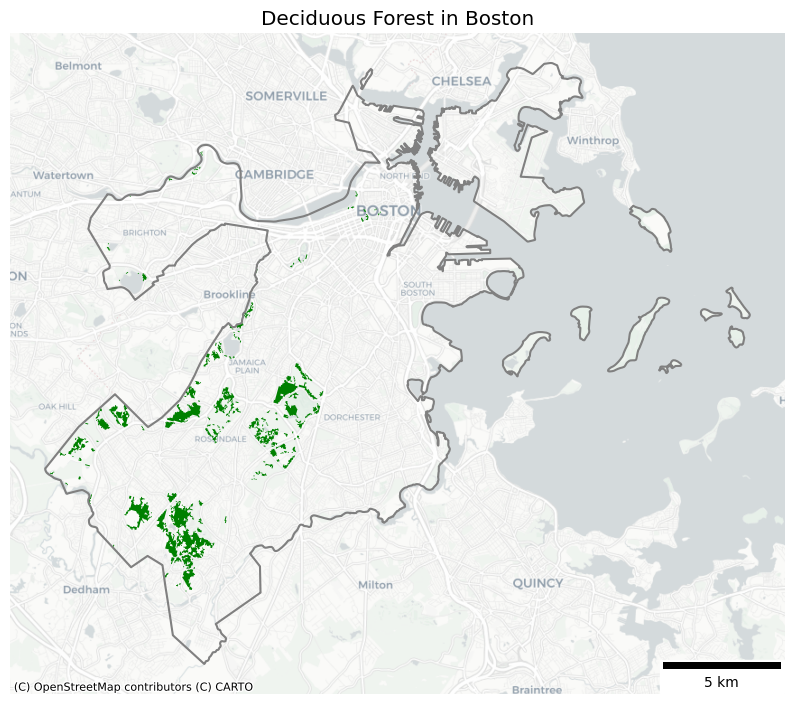

In [361]:
ax=Boston_gdf.boundary.plot(color='gray',figsize=(10,10))
forestpolygons.plot(color='green',ax=ax)
plt.title("Deciduous Forest in Boston",size='x-large')
cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.add_artist(ScaleBar(1,location='lower right'))
plt.savefig('../../../Working_Data/Deciduous forest boston.png')

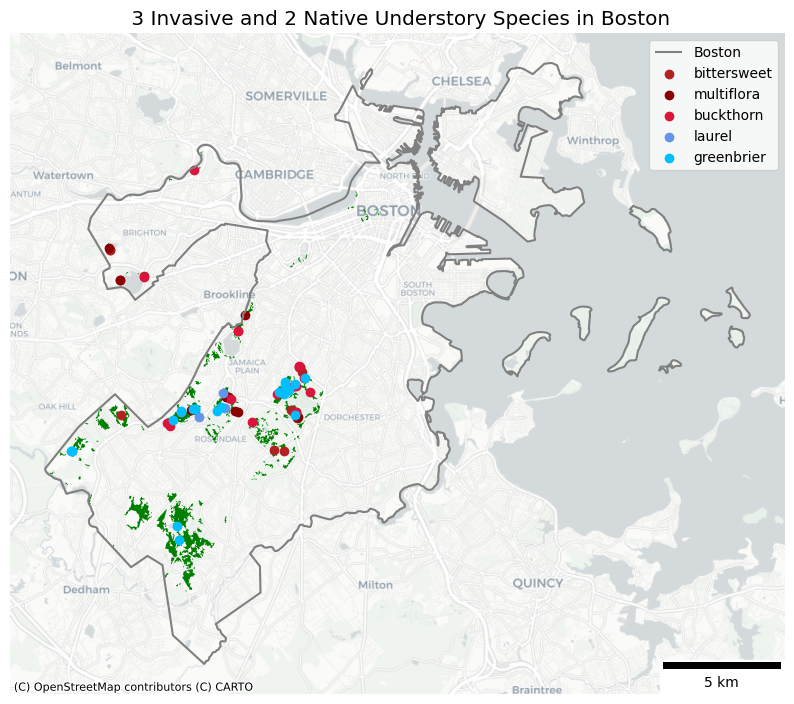

In [476]:
ax=Boston_gdf.boundary.plot(color='gray',figsize=(10,10))
forestpolygons.plot(color='green',ax=ax)
bittersweet.plot(color='firebrick',ax=ax)
multiflora.plot(color='darkred',ax=ax)
buckthorn.plot(color='crimson',ax=ax)
laurel.plot(color='cornflowerblue',ax=ax)
greenbrier.plot(color='deepskyblue',ax=ax)
plt.title(" 3 Invasive and 2 Native Understory Species in Boston",size='x-large')
cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.legend(labels=['Boston','bittersweet','multiflora','buckthorn','laurel','greenbrier'])
ax.add_artist(ScaleBar(1,location='lower right'))
plt.savefig('../../../Working_Data/iNaturalist Data.png')

In [88]:
#Append all invasives into one training set
mixedinvasives=pd.concat([buckthorn,multiflora,bittersweet,laurel,greenbrier])
mixedinvasives=mixedinvasives[['geometry','invasive']]

In [89]:
#Extract PtIDs of invasive sites
PtIDs=PointsIDCrossWalk.to_crs(epsg=3857)
sites_idx=PtIDs.sjoin_nearest(mixedinvasives,max_distance=10)['PtID']
sites=PtIDs[np.isin(PtIDs['PtID'],sites_idx)]

In [90]:
sites

index   PtID                          geometry
10243   686281  10390  POINT (-7919295.000 5200415.945)
10244   686348  10391  POINT (-7919305.000 5200415.945)
11373   761991  11525  POINT (-7919395.000 5201010.503)
11374   762058  11526  POINT (-7919405.000 5201010.503)
23294  1560697  23599  POINT (-7919215.000 5205889.989)
...        ...    ...                               ...
47686  3198913  48093  POINT (-7916195.000 5205403.279)
47688  3199047  48095  POINT (-7916205.000 5205403.279)
51109  3428254  51540  POINT (-7915305.000 5204227.167)
51114  3428589  51545  POINT (-7915295.000 5204227.167)
51338  3443597  51770  POINT (-7914845.000 5204200.132)

[147 rows x 3 columns]

In [91]:
PtIDs.sjoin_nearest(mixedinvasives,max_distance=10)[['PtID','invasive']]

PtID  invasive
10243  10390         0
10244  10391         0
11373  11525         0
11374  11526         0
23294  23599         0
...      ...       ...
47686  48093         1
47688  48095         1
51109  51540         1
51114  51545         1
51338  51770         1

[147 rows x 2 columns]

In [277]:
#Reproject joined data and add species info
joined_gdf_proj=joined_gdf.to_crs(epsg=4326)
joined_gdf_proj=pd.concat([joined_gdf_proj,PtIDs.sjoin_nearest(mixedinvasives,max_distance=10)[['invasive']]],axis=1)

In [278]:
# Determine total number of examples, and number of examples in train and test sets
frac_test=0.3
rng = np.random.default_rng(seed=121)
L=sites.shape[0]
M=int(L*(1-frac_test))
N=int(L*frac_test)

In [279]:
# Randomly select the indices for the needed number of examples from the set for train
train_indices=rng.choice(np.arange(0,L), size = M, replace = False, p = None)

# The test indices are the other rows that were not selected
test_indices=np.arange(0,L)[~np.isin(np.arange(0,L),train_indices)]

# Use indices to generate final arrays
x_train_idx=sites['PtID'].iloc[train_indices]
x_test_idx=sites['PtID'].iloc[test_indices]

In [280]:
train=joined_gdf_proj[np.isin(joined_gdf_proj['PtID'],x_train_idx)]
test=joined_gdf_proj[np.isin(joined_gdf_proj['PtID'],x_test_idx)]
validation=joined_gdf_proj[(~np.isin(joined_gdf_proj['PtID'],x_train_idx)) & (~np.isin(joined_gdf_proj['PtID'],x_test_idx))]

# Spatial RF

In [281]:
train['lon'] = train['geometry'].x
train['lat'] = train['geometry'].y
test['lon'] = test['geometry'].x
test['lat'] = test['geometry'].y
validation['lon'] = validation['geometry'].x
validation['lat'] = validation['geometry'].y

C:\Users\Chad\AppData\Roaming\Python\Python311\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\Chad\AppData\Roaming\Python\Python311\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\Chad\AppData\Roaming\Python\Python311\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [282]:
train=train.drop(['PtID','geometry'],axis=1)
test=test.drop(['PtID','geometry'],axis=1)
validation=validation.drop(['PtID','geometry'],axis=1)

In [283]:
def prepare_data(data, target, lon="lon", lat="lat"):
    """Assumes that all other columns are used as covariates"""
    covariates = [col for col in data.columns if col not in [lon, lat, target]]
    return data[covariates], data[target], data[[lon, lat]]

In [284]:
train_x, train_y, train_coords = prepare_data(
    train,'invasive'
)
test_x, test_y, test_coords = prepare_data(
    test, 'invasive'
)
validation_x, validation_y, validation_coords = prepare_data(
    validation, 'invasive'
)

# Basic RF Model

In [394]:
rf = RandomForestClassifier()
rf.fit(train_x, train_y)
test_pred = rf.predict(test_x)

rmse_rf = root_mean_squared_error(test_pred, test_y)
print("Error of basic Random Forest: ", rmse_rf)

Error of basic Random Forest:  0.2581988897471611


In [314]:
test_pred

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.])

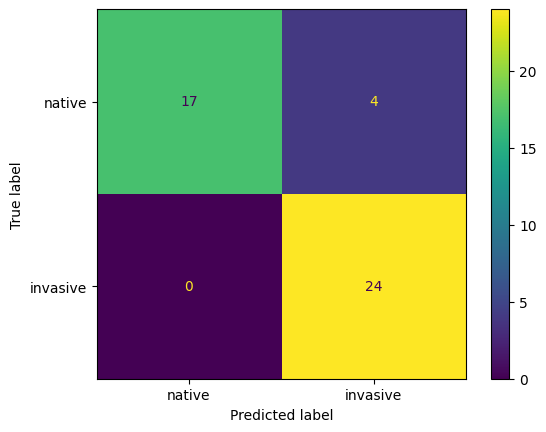

In [355]:
cm=confusion_matrix(test_y,test_pred,labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['native','invasive'])
disp.plot()
plt.savefig('../../../Working_Data/ConfusionMatrixBasicRF.png')

In [392]:
cohen_kappa_score(test_y,test_pred)

0.8192771084337349

In [469]:
%%timeit
basic_results=rf.predict(validation_x)

92 ms ± 1.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [381]:
basic_out_df=pd.DataFrame({'lon':validation_coords['lon'],'lat':validation_coords['lat'],'result':basic_results})
basic_out_gdf = gpd.GeoDataFrame(
    basic_out_df, geometry=gpd.points_from_xy(out_df.lon, out_df.lat), crs="EPSG:4326"
)

# Spatial RF

In [374]:
sp = SpatialRandomForest(
    max_depth=10, neighbors=10
)
sp.fit(train_x, train_y, train_coords)
test_pred_spatial = sp.predict(test_x, test_coords)

rmse_spatial_rf = root_mean_squared_error(test_pred, test_y)
print("Error of spatial Random Forest: ", rmse_spatial_rf)

Error of spatial Random Forest:  0.29814239699997197


C:\Users\Chad\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [375]:
test_pred_spatial

array([0.55433273, 0.19371518, 0.28566979, 0.20144618, 0.15235614,
       0.16505866, 0.26454859, 0.61810864, 0.41497356, 0.46343257,
       0.50860134, 0.51086335, 0.53374988, 0.65088173, 0.64296829,
       0.64237132, 0.62954923, 0.6942519 , 0.60132339, 0.62002772,
       0.84721348, 0.62399744, 0.62986995, 0.64242357, 0.66140776,
       0.65934514, 0.77028313, 0.42667973, 0.38592797, 0.34914621,
       0.33832975, 0.51315135, 0.27717695, 0.82277498, 0.82089505,
       0.89350279, 0.28374634, 0.95067169, 0.94089037, 0.92413297,
       0.9323301 , 0.84770884, 0.59378903, 0.65436183, 0.66933979])

In [377]:
for i in np.arange(0,test_pred_spatial.size):
    if test_pred_spatial[i] >0.5:
        test_pred_spatial[i]=1
    else:
        test_pred_spatial[i]=0
test_pred_spatial

array([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.])

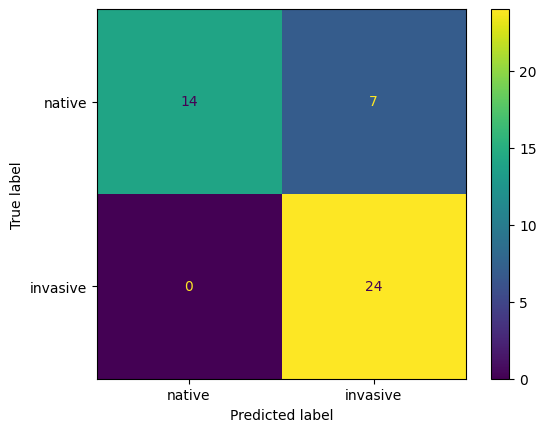

In [379]:
cm=confusion_matrix(test_y,test_pred_spatial,labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['native','invasive'])
disp.plot()
plt.savefig('../../../Working_Data/ConfusionMatrixSpatialRF.png')

In [393]:
cohen_kappa_score(test_y,test_pred_spatial)

0.6808510638297872

In [470]:
%%timeit
results=sp.predict(validation_x,validation_coords)
for i in np.arange(0,results.size):
    if results[i] >0.5:
        results[i]=1
    else:
        results[i]=0

1.69 s ± 42.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [382]:
out_df=pd.DataFrame({'lon':validation_coords['lon'],'lat':validation_coords['lat'],'result':results})

In [383]:
out_gdf = gpd.GeoDataFrame(
    out_df, geometry=gpd.points_from_xy(out_df.lon, out_df.lat), crs="EPSG:4326"
)

# Tuned Spatial RF

In [447]:
regr = SpatialRandomForest(
        n_estimators=91, neighbors=500, max_depth=10
    )
regr.tune_neighbors(train_x, train_y, train_coords)
print("spatial rf tuned:", regr.neighbors)
regr.fit(train_x, train_y, train_coords)
test_pred_regr = regr.predict(test_x, test_coords)
rmse_spatial_rf_tuned = mean_squared_error(test_pred_regr, test_y, squared=False)
print("Error of tuned spatial Random Forest: ", rmse_spatial_rf_tuned)

C:\Users\Chad\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Chad\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Chad\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Chad\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmea

spatial rf tuned: 83


C:\Users\Chad\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Error of tuned spatial Random Forest:  0.3526166287845398


C:\Users\Chad\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [448]:
test_pred_regr

array([0.01048485, 0.        , 0.20535842, 0.0572365 , 0.20565025,
       0.02974036, 0.11976309, 0.61416274, 0.50395696, 0.3129207 ,
       0.08575894, 0.39660832, 0.42100733, 0.62517768, 0.5007478 ,
       0.94340443, 0.94338486, 0.61554429, 1.        , 0.90854693,
       0.99168943, 0.89374269, 0.91464088, 0.96010244, 0.99271896,
       0.96160694, 0.91017857, 0.8532572 , 0.        , 0.        ,
       0.01857456, 1.        , 0.2809955 , 0.55379438, 0.48718207,
       1.        , 0.59188106, 0.9356044 , 0.88747038, 0.81446838,
       0.98751106, 0.65554594, 0.17516205, 0.57254237, 0.60567715])

In [449]:
for i in np.arange(0,test_pred_regr.size):
    if test_pred_regr[i] >0.5:
        test_pred_regr[i]=1
    else:
        test_pred_regr[i]=0
test_pred_regr

array([0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.])

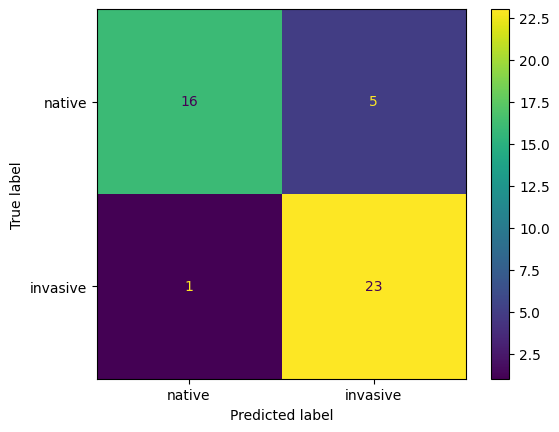

In [450]:
cm=confusion_matrix(test_y,test_pred_regr,labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['native','invasive'])
disp.plot()
plt.savefig('../../../Working_Data/ConfusionTunedMatrixSpatialRF.png')

In [451]:
cohen_kappa_score(test_y,test_pred_regr)

0.7289156626506024

In [471]:
%%timeit
results=regr.predict(validation_x,validation_coords)
for i in np.arange(0,results.size):
    if results[i] >0.5:
        results[i]=1
    else:
        results[i]=0

1.58 s ± 50 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [453]:
tuned_out_df=pd.DataFrame({'lon':validation_coords['lon'],'lat':validation_coords['lat'],'result':results})

In [454]:
tuned_out_gdf = gpd.GeoDataFrame(
    tuned_out_df, geometry=gpd.points_from_xy(out_df.lon, out_df.lat), crs="EPSG:4326"
)

# Geographic RF

In [422]:
geo_rf = GeographicalRandomForest(
    n_estimators=100, neighbors=10, max_depth=10
)
geo_rf.fit(train_x, train_y, train_coords)
test_pred_geo = geo_rf.predict(test_x, test_coords)

rmse_geo_rf = mean_squared_error(test_pred_geo, test_y, squared=False)
print("Error of spatial Random Forest: ", rmse_geo_rf)

Error of spatial Random Forest:  0.21592179654268864


C:\Users\Chad\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [423]:
test_pred_geo

array([[0.13],
       [0.04],
       [0.18],
       [0.08],
       [0.05],
       [0.04],
       [0.25],
       [0.93],
       [0.02],
       [0.08],
       [0.  ],
       [0.02],
       [0.03],
       [1.  ],
       [1.  ],
       [1.  ],
       [1.  ],
       [1.  ],
       [0.98],
       [0.95],
       [0.94],
       [0.94],
       [0.82],
       [0.83],
       [0.81],
       [0.79],
       [0.92],
       [0.33],
       [0.09],
       [0.07],
       [0.04],
       [0.68],
       [0.15],
       [0.97],
       [0.97],
       [1.  ],
       [0.53],
       [0.95],
       [0.95],
       [0.94],
       [0.98],
       [0.81],
       [0.13],
       [0.94],
       [0.92]])

In [424]:
for i in np.arange(0,test_pred_geo.size):
    if test_pred_geo[i] >0.5:
        test_pred_geo[i]=1
    else:
        test_pred_geo[i]=0
test_pred_geo

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.]])

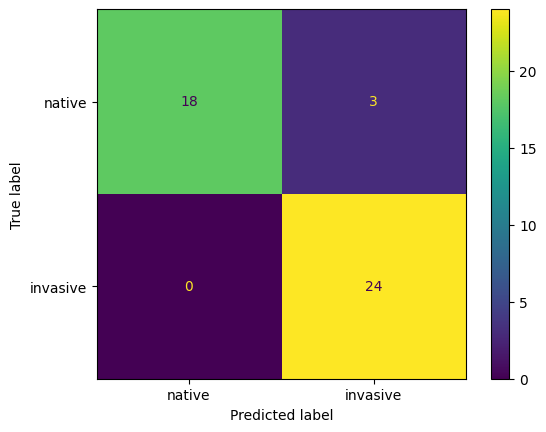

In [425]:
cm=confusion_matrix(test_y,test_pred_geo,labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['native','invasive'])
disp.plot()
plt.savefig('../../../Working_Data/ConfusionMatrixGeoRF.png')

In [426]:
cohen_kappa_score(test_y,test_pred_geo)

0.8648648648648649

In [472]:
%%timeit
results=geo_rf.predict(validation_x,validation_coords)
for i in np.arange(0,results.size):
    if results[i] >0.5:
        results[i]=1
    else:
        results[i]=0

2min 31s ± 7.2 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [432]:
geo_out_df=pd.DataFrame({'lon':validation_coords['lon'],'lat':validation_coords['lat'],'result':np.ravel(results)})

In [433]:
geo_out_gdf = gpd.GeoDataFrame(
    geo_out_df, geometry=gpd.points_from_xy(out_df.lon, out_df.lat), crs="EPSG:4326"
)

# Predicted Area

In [456]:
basic_out_gdf.groupby('result').count()

lon    lat  geometry
result                        
0.0     30802  30802     30802
1.0     21673  21673     21673

In [457]:
21673/(21673+30802)

0.4130157217722725

In [458]:
out_gdf.groupby('result').count()

lon    lat  geometry
result                        
0.0     15210  15210     15210
1.0     37265  37265     37265

In [459]:
37265/(37265+15210)

0.7101476893758932

In [465]:
tuned_out_gdf.groupby('result').count()

lon    lat  geometry
result                        
0.0     34316  34316     34316
1.0     18159  18159     18159

In [466]:
18159/(18159+34316)

0.34605050023820866

In [467]:
geo_out_gdf.groupby('result').count()

lon    lat  geometry
result                        
0.0     34590  34590     34590
1.0     17885  17885     17885

In [468]:
17885/(17885+34590)

0.34082896617436875

# Plots

In [460]:
out_grid= make_geocube(vector_data=out_gdf.to_crs(epsg=3857), measurements=["result"], resolution=(-30, 30))
basic_out_grid=make_geocube(vector_data=basic_out_gdf.to_crs(epsg=3857), measurements=["result"], resolution=(-30, 30))
tuned_out_grid=make_geocube(vector_data=tuned_out_gdf.to_crs(epsg=3857), measurements=["result"], resolution=(-30, 30))
geo_out_grid=make_geocube(vector_data=geo_out_gdf.to_crs(epsg=3857), measurements=["result"], resolution=(-30, 30))

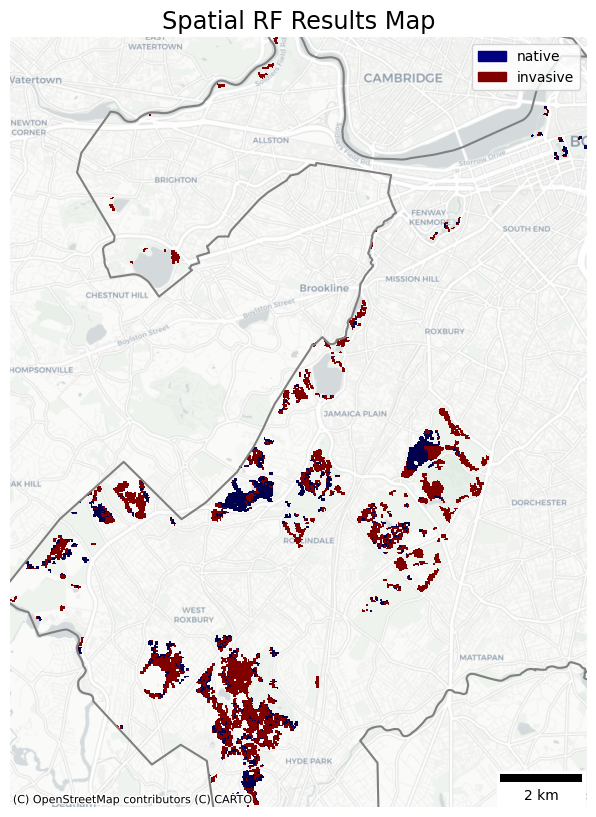

In [474]:
fig, ax =plt.subplots(figsize=(10,10))
Boston_gdf.boundary.plot(color='gray',ax=ax)
img=out_grid['result'].plot(cmap='seismic',ax=ax)
ax.set_axis_off()
img.colorbar.remove()
blue_patch = mpl.patches.Patch(color='navy', label='native')
red_patch = mpl.patches.Patch(color='maroon', label='invasive')
ax.legend(handles=[blue_patch,red_patch])
cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)
ax.add_artist(ScaleBar(1,location='lower right'))
plt.title('Spatial RF Results Map',size='xx-large')
plt.savefig('../../../Working_Data/SpatialRFResults.png')

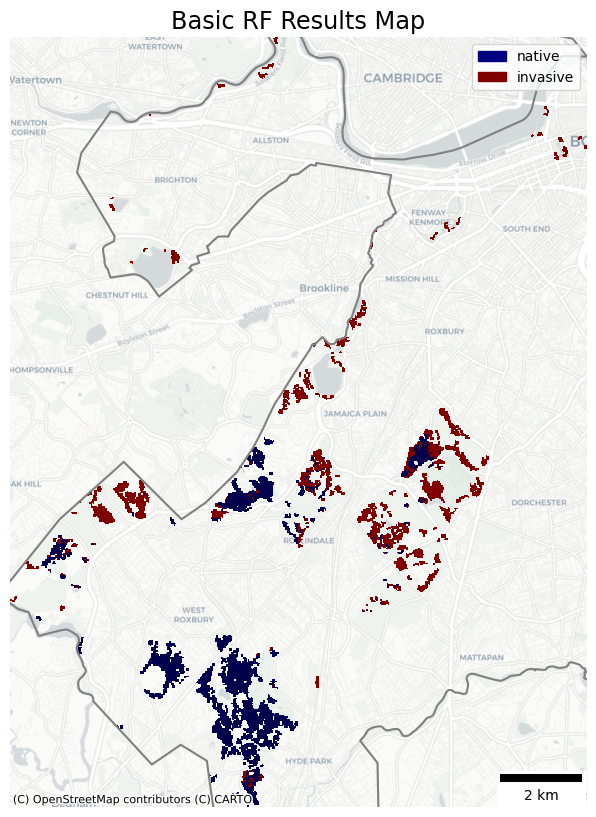

In [462]:
fig, ax =plt.subplots(figsize=(10,10))
Boston_gdf.boundary.plot(color='gray',ax=ax)
img=basic_out_grid['result'].plot(cmap='seismic',ax=ax)
ax.set_axis_off()
img.colorbar.remove()
blue_patch = mpl.patches.Patch(color='navy', label='native')
red_patch = mpl.patches.Patch(color='maroon', label='invasive')
ax.legend(handles=[blue_patch,red_patch])
cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)
ax.add_artist(ScaleBar(1,location='lower right'))
plt.title('Basic RF Results Map',size='xx-large')
plt.savefig('../../../Working_Data/RFResults.png')

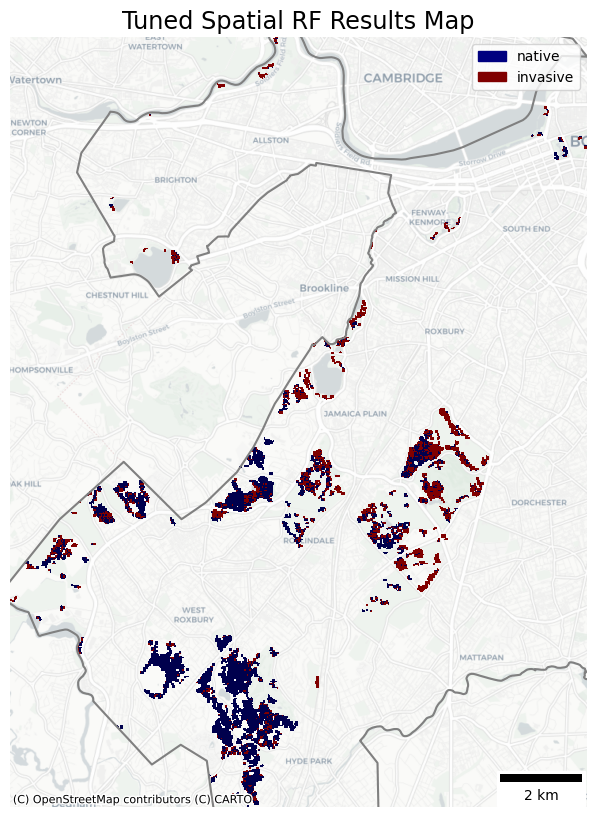

In [463]:
fig, ax =plt.subplots(figsize=(10,10))
Boston_gdf.boundary.plot(color='gray',ax=ax)
img=tuned_out_grid['result'].plot(cmap='seismic',ax=ax)
ax.set_axis_off()
img.colorbar.remove()
blue_patch = mpl.patches.Patch(color='navy', label='native')
red_patch = mpl.patches.Patch(color='maroon', label='invasive')
ax.legend(handles=[blue_patch,red_patch])
cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)
ax.add_artist(ScaleBar(1,location='lower right'))
plt.title('Tuned Spatial RF Results Map',size='xx-large')
plt.savefig('../../../Working_Data/TunedRFResults.png')

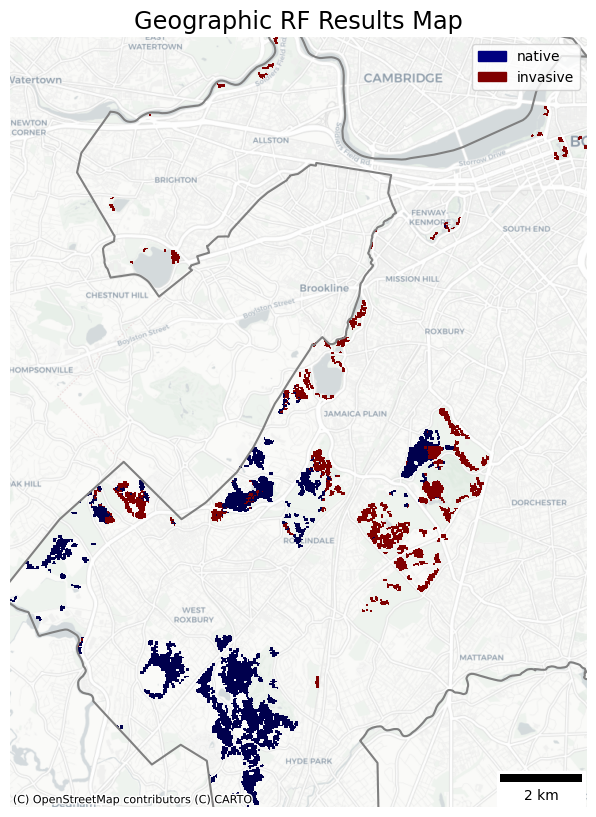

In [464]:
fig, ax =plt.subplots(figsize=(10,10))
Boston_gdf.boundary.plot(color='gray',ax=ax)
img=geo_out_grid['result'].plot(cmap='seismic',ax=ax)
ax.set_axis_off()
img.colorbar.remove()
blue_patch = mpl.patches.Patch(color='navy', label='native')
red_patch = mpl.patches.Patch(color='maroon', label='invasive')
ax.legend(handles=[blue_patch,red_patch])
cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)
ax.add_artist(ScaleBar(1,location='lower right'))
plt.title('Geographic RF Results Map',size='xx-large')
plt.savefig('../../../Working_Data/GeoRFResults.png')

# Generate example plots from observations

In [135]:
mygdf=gpd.read_file('../../../Working_Data/2023BandsIndicesCleaned.shp',engine="pyogrio").dropna()

In [136]:
def harmonicfunc(mult,one,two,x):
    w=2*np.pi/365.25
    return one*np.cos(mult*w*x)+two*np.sin(mult*w*x)

In [137]:
def myobj(x,a,b,c,d,e,f,g,h,i):  
    return a+harmonicfunc(1,b,c,x)+harmonicfunc(2,d,e,x)+harmonicfunc(3,f,g,x)+harmonicfunc(4,h,i,x)

In [162]:
def curvefit(PtID,band):
    x=mygdf[mygdf['PtID']==PtID]['DOY']
    y=mygdf[mygdf['PtID']==PtID][band]
    popt,pcov=scipy.optimize.curve_fit(myobj, x,y)
    yhat=myobj(x,popt[0],popt[1],popt[2],popt[3],popt[4],popt[5],popt[6],popt[7],popt[8])
    RMSE=np.sqrt(mean_squared_error(y, yhat))
    return x,y,yhat

In [216]:
TRAIN_TEST=joined_gdf_proj[(np.isin(joined_gdf_proj['PtID'],x_train_idx)) | (np.isin(joined_gdf_proj['PtID'],x_test_idx))]

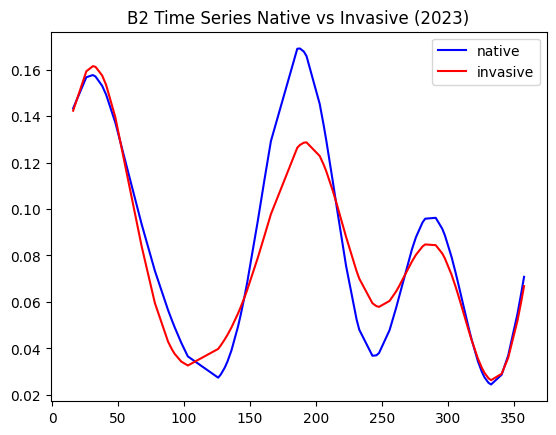

In [248]:
band='SAVI'
NDVI_coeffs_nat=TRAIN_TEST[TRAIN_TEST['invasive']==0][['a'+band,'b'+band,'c'+band,'d'+band,'e'+band,'f'+band,'g'+band,'h'+band,'i'+band]]
NDVI_coeffs_nat=NDVI_coeffs_nat.mean()
x=mygdf[mygdf['PtID']==PtID]['DOY']
yhat=myobj(x,NDVI_coeffs_nat.iloc[0],NDVI_coeffs_nat.iloc[1],NDVI_coeffs_nat.iloc[2],NDVI_coeffs_nat.iloc[3],NDVI_coeffs_nat.iloc[4],NDVI_coeffs_nat.iloc[5],NDVI_coeffs_nat.iloc[6],NDVI_coeffs_nat.iloc[7],NDVI_coeffs_nat.iloc[8])
plt.plot(x,yhat,color='blue')
NDVI_coeffs_inv=TRAIN_TEST[TRAIN_TEST['invasive']==1][['a'+band,'b'+band,'c'+band,'d'+band,'e'+band,'f'+band,'g'+band,'h'+band,'i'+band]]
NDVI_coeffs_inv=NDVI_coeffs_inv.mean()
x=mygdf[mygdf['PtID']==PtID]['DOY']
yhat=myobj(x,NDVI_coeffs_inv.iloc[0],NDVI_coeffs_inv.iloc[1],NDVI_coeffs_inv.iloc[2],NDVI_coeffs_inv.iloc[3],NDVI_coeffs_inv.iloc[4],NDVI_coeffs_inv.iloc[5],NDVI_coeffs_inv.iloc[6],NDVI_coeffs_inv.iloc[7],NDVI_coeffs_inv.iloc[8])
plt.plot(x,yhat,color='red')
plt.title(band+' Time Series Native vs Invasive (2023)')
plt.legend(['native','invasive'])
plt.savefig(band+'_timeseries.png')

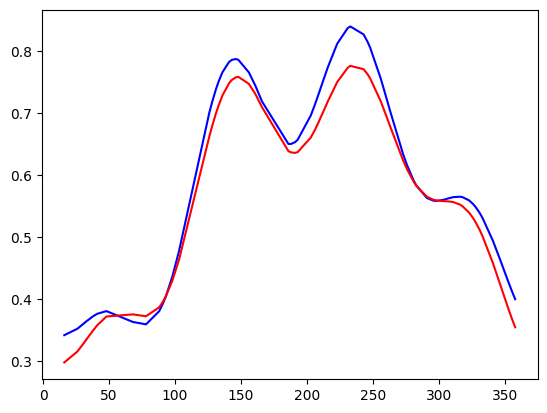

In [218]:
NDVI_coeffs_nat=TRAIN_TEST[TRAIN_TEST['invasive']==0][['aNDVI','bNDVI','cNDVI','dNDVI','eNDVI','fNDVI','gNDVI','hNDVI','iNDVI']]
NDVI_coeffs_nat=NDVI_coeffs_nat.mean()
x=mygdf[mygdf['PtID']==PtID]['DOY']
yhat=myobj(x,NDVI_coeffs_nat.iloc[0],NDVI_coeffs_nat.iloc[1],NDVI_coeffs_nat.iloc[2],NDVI_coeffs_nat.iloc[3],NDVI_coeffs_nat.iloc[4],NDVI_coeffs_nat.iloc[5],NDVI_coeffs_nat.iloc[6],NDVI_coeffs_nat.iloc[7],NDVI_coeffs_nat.iloc[8])
plt.plot(x,yhat,color='blue')
NDVI_coeffs_inv=TRAIN_TEST[TRAIN_TEST['invasive']==1][['aNDVI','bNDVI','cNDVI','dNDVI','eNDVI','fNDVI','gNDVI','hNDVI','iNDVI']]
NDVI_coeffs_inv=NDVI_coeffs_inv.mean()
x=mygdf[mygdf['PtID']==PtID]['DOY']
yhat=myobj(x,NDVI_coeffs_inv.iloc[0],NDVI_coeffs_inv.iloc[1],NDVI_coeffs_inv.iloc[2],NDVI_coeffs_inv.iloc[3],NDVI_coeffs_inv.iloc[4],NDVI_coeffs_inv.iloc[5],NDVI_coeffs_inv.iloc[6],NDVI_coeffs_inv.iloc[7],NDVI_coeffs_inv.iloc[8])
plt.plot(x,yhat,color='red')

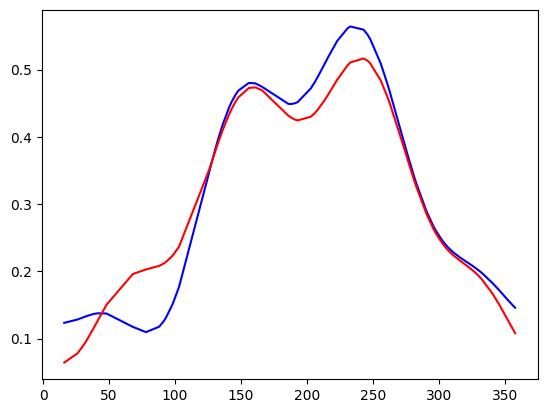

In [219]:
NDVI_coeffs_nat=TRAIN_TEST[TRAIN_TEST['invasive']==0][['aRENDVI','bRENDVI','cRENDVI','dRENDVI','eRENDVI','fRENDVI','gRENDVI','hRENDVI','iRENDVI']]
NDVI_coeffs_nat=NDVI_coeffs_nat.mean()
x=mygdf[mygdf['PtID']==PtID]['DOY']
yhat=myobj(x,NDVI_coeffs_nat.iloc[0],NDVI_coeffs_nat.iloc[1],NDVI_coeffs_nat.iloc[2],NDVI_coeffs_nat.iloc[3],NDVI_coeffs_nat.iloc[4],NDVI_coeffs_nat.iloc[5],NDVI_coeffs_nat.iloc[6],NDVI_coeffs_nat.iloc[7],NDVI_coeffs_nat.iloc[8])
plt.plot(x,yhat,color='blue')
NDVI_coeffs_inv=TRAIN_TEST[TRAIN_TEST['invasive']==1][['aRENDVI','bRENDVI','cRENDVI','dRENDVI','eRENDVI','fRENDVI','gRENDVI','hRENDVI','iRENDVI']]
NDVI_coeffs_inv=NDVI_coeffs_inv.mean()
x=mygdf[mygdf['PtID']==PtID]['DOY']
yhat=myobj(x,NDVI_coeffs_inv.iloc[0],NDVI_coeffs_inv.iloc[1],NDVI_coeffs_inv.iloc[2],NDVI_coeffs_inv.iloc[3],NDVI_coeffs_inv.iloc[4],NDVI_coeffs_inv.iloc[5],NDVI_coeffs_inv.iloc[6],NDVI_coeffs_inv.iloc[7],NDVI_coeffs_inv.iloc[8])
plt.plot(x,yhat,color='red')

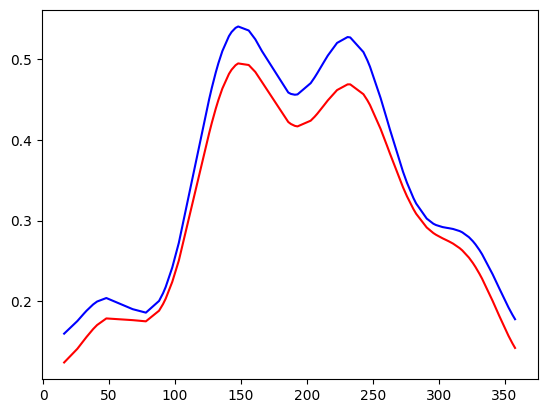

In [220]:
NDVI_coeffs_nat=TRAIN_TEST[TRAIN_TEST['invasive']==0][['aSAVI','bSAVI','cSAVI','dSAVI','eSAVI','fSAVI','gSAVI','hSAVI','iSAVI']]
NDVI_coeffs_nat=NDVI_coeffs_nat.mean()
x=mygdf[mygdf['PtID']==PtID]['DOY']
yhat=myobj(x,NDVI_coeffs_nat.iloc[0],NDVI_coeffs_nat.iloc[1],NDVI_coeffs_nat.iloc[2],NDVI_coeffs_nat.iloc[3],NDVI_coeffs_nat.iloc[4],NDVI_coeffs_nat.iloc[5],NDVI_coeffs_nat.iloc[6],NDVI_coeffs_nat.iloc[7],NDVI_coeffs_nat.iloc[8])
plt.plot(x,yhat,color='blue')
NDVI_coeffs_inv=TRAIN_TEST[TRAIN_TEST['invasive']==1][['aSAVI','bSAVI','cSAVI','dSAVI','eSAVI','fSAVI','gSAVI','hSAVI','iSAVI']]
NDVI_coeffs_inv=NDVI_coeffs_inv.mean()
x=mygdf[mygdf['PtID']==PtID]['DOY']
yhat=myobj(x,NDVI_coeffs_inv.iloc[0],NDVI_coeffs_inv.iloc[1],NDVI_coeffs_inv.iloc[2],NDVI_coeffs_inv.iloc[3],NDVI_coeffs_inv.iloc[4],NDVI_coeffs_inv.iloc[5],NDVI_coeffs_inv.iloc[6],NDVI_coeffs_inv.iloc[7],NDVI_coeffs_inv.iloc[8])
plt.plot(x,yhat,color='red')

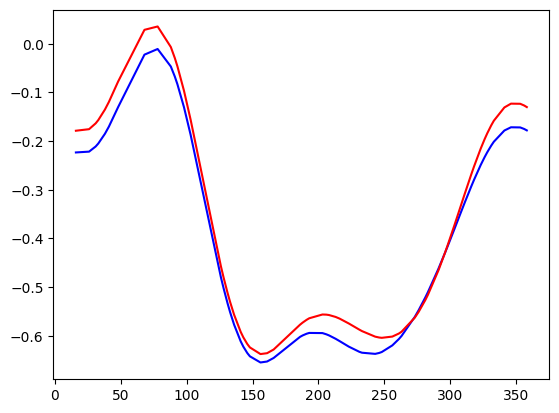

In [221]:
NDVI_coeffs_nat=TRAIN_TEST[TRAIN_TEST['invasive']==0][['aNBR','bNBR','cNBR','dNBR','eNBR','fNBR','gNBR','hNBR','iNBR']]
NDVI_coeffs_nat=NDVI_coeffs_nat.mean()
x=mygdf[mygdf['PtID']==PtID]['DOY']
yhat=myobj(x,NDVI_coeffs_nat.iloc[0],NDVI_coeffs_nat.iloc[1],NDVI_coeffs_nat.iloc[2],NDVI_coeffs_nat.iloc[3],NDVI_coeffs_nat.iloc[4],NDVI_coeffs_nat.iloc[5],NDVI_coeffs_nat.iloc[6],NDVI_coeffs_nat.iloc[7],NDVI_coeffs_nat.iloc[8])
plt.plot(x,yhat,color='blue')
NDVI_coeffs_inv=TRAIN_TEST[TRAIN_TEST['invasive']==1][['aNBR','bNBR','cNBR','dNBR','eNBR','fNBR','gNBR','hNBR','iNBR']]
NDVI_coeffs_inv=NDVI_coeffs_inv.mean()
x=mygdf[mygdf['PtID']==PtID]['DOY']
yhat=myobj(x,NDVI_coeffs_inv.iloc[0],NDVI_coeffs_inv.iloc[1],NDVI_coeffs_inv.iloc[2],NDVI_coeffs_inv.iloc[3],NDVI_coeffs_inv.iloc[4],NDVI_coeffs_inv.iloc[5],NDVI_coeffs_inv.iloc[6],NDVI_coeffs_inv.iloc[7],NDVI_coeffs_inv.iloc[8])
plt.plot(x,yhat,color='red')

In [ ]:
    plt.scatter(x,y,marker='*',color=col)
    plt.plot(x,yhat,color=col)

In [165]:
img_dates=mygdf[['DOY']]
img_dates['x']=1

C:\Users\Chad\AppData\Local\Temp\ipykernel_2684\1002680523.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  img_dates['x']=1


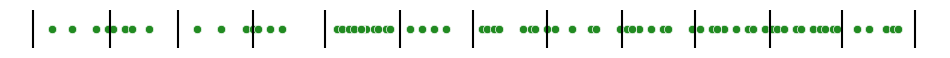

In [363]:
fig,ax=plt.subplots(figsize=(12,0.5))
sns.scatterplot(img_dates,x='DOY',y='x',ax=ax,color='forestgreen')
loc=[0,32,60,91,121,152,182,213,244,274,305,335,365]
for x in loc:
    plt.axvline(x=x,color='black')
ax.set_axis_off()
ax.set_ylim([0.8,1.2])
plt.savefig('../../../Working_Data/images density.png')

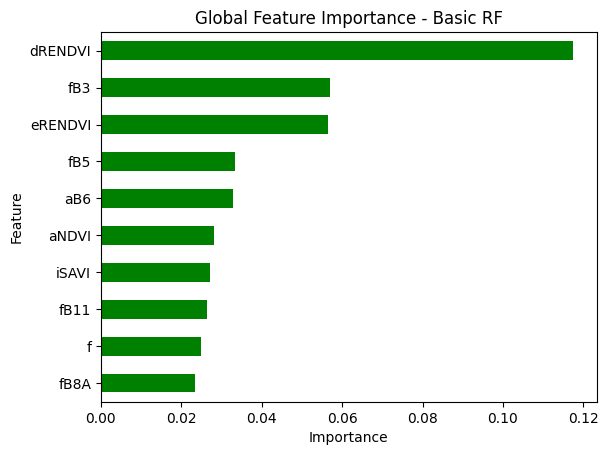

In [260]:
global_importances = pd.Series(rf.feature_importances_, index=train_x.columns)
global_importances.sort_values(ascending=True, inplace=True)
global_importances[-10:].plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - Basic RF")
plt.savefig('Feature Importance.png')